##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 베이지안 가우시안 혼합 모델 및 해밀턴 MCMC

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소그 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/probability/examples/Bayesian_Gaussian_Mixture_Model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 colab에서는 TensorFlow Probability 기본 형식만 사용하여 베이지안 가우시안 혼합 모델(BGMM)의 사후 확률에서 샘플링을 탐색합니다.

## 모델

각 차원 $D$의 $k\in{1,\ldots,K}$ 혼합 구성 요소에 대해 다음의 베이지안 가우시안 혼합 모델로 $i\in{1,\ldots,N}$ iid 샘플을 모델링하려고 합니다.

$$\begin{align*} \theta &amp;\sim \text{Dirichlet}(\text{concentration}=\alpha_0)\ \mu_k &amp;\sim \text{Normal}(\text{loc}=\mu_{0k}, \text{scale}=I_D)\ T_k &amp;\sim \text{Wishart}(\text{df}=5, \text{scale}=I_D)\ Z_i &amp;\sim \text{Categorical}(\text{probs}=\theta)\ Y_i &amp;\sim \text{Normal}(\text{loc}=\mu_{z_i}, \text{scale}=T_{z_i}^{-1/2})\ \end{align*}$$

`scale` 인수는 모두 `cholesky` 의미 체계를 가지고 있습니다. 이 규칙은 TF 분포의 규칙이기 때문에 사용됩니다(계산적으로 유리하므로 TF 분포에서 부분적으로 이 규칙을 사용합니다).

목표는 다음의 사후 확률에서 샘플을 생성하는 것입니다.

$$p\left(\theta, {\mu_k, T_k}*{k=1}^K \Big| {y_i}*{i=1}^N, \alpha_0, {\mu_{ok}}_{k=1}^K\right)$$

${Z_i}_{i=1}^N$는 존재하지 않는다는 점에 유의하세요. $N$로 조정되지 않는 확률 변수에만 관심을 둡니다(또한, 운 좋게도 $Z_i$를 무시하는 TF 분포가 있습니다).

계산적으로 다루기 힘든 정규화 항으로 인해 이 분포에서 직접 샘플링하는 것은 불가능합니다.

[메트로폴리스-헤이스팅스 알고리즘](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)은 다루기 힘든 정규화된 분포에서 샘플링하는 기술입니다.

TensorFlow Probability는 메트로폴리스-헤이스팅스 기반의 여러 옵션을 포함하여 많은 MCMC 옵션을 제공합니다. 이 노트북에서는 [해밀턴 몬테카를로](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)(`tfp.mcmc.HamiltonianMonteCarlo`)를 사용합니다. 해밀턴 몬테카를로(HMC)는 신속하게 수렴하고 (좌표 방식이 아닌) 상태 공간을 공동으로 샘플링하며, TF의 장점 중 하나인 자동 미분을 활용하므로 종종 좋은 선택입니다. 즉, BGMM 사후 확률에서의 샘플링은 실제로 [Gibb의 샘플링](https://en.wikipedia.org/wiki/Gibbs_sampling)과 같은 다른 접근 방식을 사용하면 더 잘 수행될 수 있습니다.

In [ ]:
%matplotlib inline


import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

실제로 모델을 빌드하기 전에 새로운 유형의 분포를 정의해야 합니다. 위의 모델 사양에서 역공분산 행렬, 즉 [정밀 행렬](https://en.wikipedia.org/wiki/Precision_(statistics%29))로 MVN을 매개변수화하고 있음이 분명합니다. 이를 TF에서 달성하려면, `Bijector`를 롤 아웃해야 합니다. 이 `Bijector`는 순방향 변환을 사용합니다.

- `Y =  tf.linalg.triangular_solve((tf.linalg.matrix_transpose(chol_precision_tril), X, adjoint=True) + loc`.

그리고 `log_prob` 계산은 그 반대입니다. 즉, 이 계산은 다음과 같습니다.

- `X = tf.linalg.matmul(chol_precision_tril, X - loc, adjoint_a=True)`.

HMC에 필요한 것은 `log_prob` 뿐이므로, (`tfd.MultivariateNormalTriL`의 경우처럼) `tf.linalg.triangular_solve`를 호출하지 않습니다. 이는 `tf.linalg.matmul`이 일반적으로 더 나은 캐시 위치로 인해 더 빠르기 때문에 유리합니다.


In [ ]:
class MVNCholPrecisionTriL(tfd.TransformedDistribution):
  """MVN from loc and (Cholesky) precision matrix."""

  def __init__(self, loc, chol_precision_tril, name=None):
    super(MVNCholPrecisionTriL, self).__init__(
        distribution=tfd.Independent(tfd.Normal(tf.zeros_like(loc),
                                                scale=tf.ones_like(loc)),
                                     reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Shift(shift=loc),
            tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=chol_precision_tril,
                                           adjoint=True)),
        ]),
        name=name)

`tfd.Independent` 분포는 한 분포의 독립적인 그리기를 통계적으로 독립된 좌표가 있는 다변량 분포로 바꿉니다. `log_prob` 계산 측면에서, 이 '메타 분포'는 이벤트 차원에 대한 단순 합계로 나타납니다.

또한 scale 행렬의 `adjoint` ('transpose')를 사용했습니다. 그 이유는 정밀도가 역공분산이면, 즉 $P=C^{-1}$이고 $C=AA^\top$이면, $P=BB^{\top}$이고 여기서 $B=A^{-\top}$입니다.

이 분포는 다소 까다로우므로 `MVNCholPrecisionTriL`이 예상되는 대로 동작하는지 빠르게 확인하겠습니다.

In [ ]:
def compute_sample_stats(d, seed=42, n=int(1e6)):
  x = d.sample(n, seed=seed)
  sample_mean = tf.reduce_mean(x, axis=0, keepdims=True)
  s = x - sample_mean
  sample_cov = tf.linalg.matmul(s, s, adjoint_a=True) / tf.cast(n, s.dtype)
  sample_scale = tf.linalg.cholesky(sample_cov)
  sample_mean = sample_mean[0]
  return [
      sample_mean,
      sample_cov,
      sample_scale,
  ]

dtype = np.float32
true_loc = np.array([1., -1.], dtype=dtype)
true_chol_precision = np.array([[1., 0.],
                                [2., 8.]],
                               dtype=dtype)
true_precision = np.matmul(true_chol_precision, true_chol_precision.T)
true_cov = np.linalg.inv(true_precision)

d = MVNCholPrecisionTriL(
    loc=true_loc,
    chol_precision_tril=true_chol_precision)

[sample_mean, sample_cov, sample_scale] = [
    t.numpy() for t in compute_sample_stats(d)]

print('true mean:', true_loc)
print('sample mean:', sample_mean)
print('true cov:\n', true_cov)
print('sample cov:\n', sample_cov)

true mean: [ 1. -1.]
sample mean: [ 1.0002806 -1.000105 ]
true cov:
 [[ 1.0625   -0.03125 ]
 [-0.03125   0.015625]]
sample cov:
 [[ 1.0641273  -0.03126175]
 [-0.03126175  0.01559312]]


샘플 평균과 공분산이 실제 평균과 공분산에 가까우므로 분포가 올바르게 구현된 것처럼 보입니다. 이제 `MVNCholPrecisionTriL` `tfp.distributions.JointDistributionNamed`로 BGMM 모델을 지정합니다. 관찰 모델의 경우, `tfd.MixtureSameFamily`를 사용하여 ${Z_i}_{i=1}^N$ 그리기를 자동으로 통합합니다.

In [ ]:
dtype = np.float64
dims = 2
components = 3
num_samples = 1000

In [ ]:
bgmm = tfd.JointDistributionNamed(dict(
  mix_probs=tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.),
  loc=tfd.Independent(
    tfd.Normal(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=2),
  precision=tfd.Independent(
    tfd.WishartTriL(
        df=5,
        scale_tril=np.stack([np.eye(dims, dtype=dtype)]*components),
        input_output_cholesky=True),
    reinterpreted_batch_ndims=1),
  s=lambda mix_probs, loc, precision: tfd.Sample(tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=MVNCholPrecisionTriL(
          loc=loc,
          chol_precision_tril=precision)),
      sample_shape=num_samples)
))

In [ ]:
def joint_log_prob(observations, mix_probs, loc, chol_precision):
  """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

  Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `Dirichlet` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
  """
  return bgmm.log_prob(
      mix_probs=mix_probs, loc=loc, precision=chol_precision, s=observations)

## '훈련' 데이터를 생성합니다.

다음 데모에서는 무작위의 데이터를 샘플링합니다.

In [ ]:
true_loc = np.array([[-2., -2],
                     [0, 0],
                     [2, 2]], dtype)
random = np.random.RandomState(seed=43)

true_hidden_component = random.randint(0, components, num_samples)
observations = (true_loc[true_hidden_component] +
                random.randn(num_samples, dims).astype(dtype))

## HMC를 사용한 베이지안 추론

이제 TFD를 사용하여 모델을 지정하고 일부 관찰 데이터를 얻었으므로 HMC를 실행하는 데 필요한 모든 부분을 확보했습니다.

HMC를 실행하려면 [부분 적용](https://en.wikipedia.org/wiki/Partial_application)을 사용하여 샘플링하고 싶지 않은 항목을 '고정'합니다. 이 경우에는 `observations`만 고정하면 됩니다(하이퍼 매개변수는 이미 사전 확률 분포에 적용되었으며 `joint_log_prob` 함수 서명의 일부가 아닙니다).

In [ ]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, observations)

In [ ]:
initial_state = [
    tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs'),
    tf.constant(np.array([[-2., -2],
                          [0, 0],
                          [2, 2]], dtype),
                name='loc'),
    tf.linalg.eye(dims, batch_shape=[components], dtype=dtype, name='chol_precision'),
]

### 제약 조건이 없는 표현

해밀턴 몬테카를로(HMC)는 인수와 관련하여 대상 로그 확률 함수를 미분할 수 있어야 합니다. 또한 HMC는 상태 공간에 제약 조건이 없는 경우 훨씬 더 높은 통계 효율성을 나타낼 수 있습니다.

즉, BGMM 사후 확률에서 샘플링할 때 두 가지 주요 문제를 해결해야 합니다.

1. $\theta$는 이산 확률 벡터를 나타냅니다. 즉, $\sum_{k=1}^K \theta_k = 1$ 및 $\theta_k&gt;0$와 같아야 합니다.
2. $T_k$는 역공분산 행렬을 나타냅니다. 즉, $T_k \succ 0$가 되어야 합니다. 이는 [양정치](https://en.wikipedia.org/wiki/Positive-definite_matrix)가 됩니다.


위의 요구 사항을 해결하려면 다음을 수행해야 합니다.

1. 제약 조건이 있는 변수를 제약 조건이 없는 공간으로 변환합니다.
2. 제약 조건이 없는 공간에서 MCMC를 실행합니다.
3. 제약 조건이 없는 변수를 제약 조건이 있는 공간으로 다시 변환합니다.

`MVNCholPrecisionTriL`과 마찬가지로, 제약 조건이 없는 공간으로 확률 변수를 변환하려면 [`Bijector`](https://www.tensorflow.org/api_docs/python/tf/distributions/bijectors/Bijector)를 사용합니다.

- [`Dirichlet`](https://en.wikipedia.org/wiki/Dirichlet_distribution)은 [softmax 함수](https://en.wikipedia.org/wiki/Softmax_function)를 통해 제약 조건이 없는 공간으로 변환됩니다.

- 정밀도 확률 변수는 준 양정치 행렬에 대한 분포입니다. 이들에 대한 제약 조건을 없애기 위해서는 `FillTriangular` 및 `TransformDiagonal` bijector를 사용합니다. 이들 bijector는 벡터를 하부 삼각 행렬로 변환하고 대각선이 양수인지 확인합니다. 전자는 $d^2$ 대신 $d(d+1)/2$ float만 샘플링할 수 있으므로 유용합니다.

In [ ]:
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular(),
    ])]

In [ ]:
@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=500,
    current_state=initial_state,
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=5),
            bijector=unconstraining_bijectors),
         num_adaptation_steps=400),
    trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

[mix_probs, loc, chol_precision], is_accepted = sample()

이제 chain을 실행하고 사후 확률 분포의 평균을 출력합니다.

In [ ]:
acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_mix_probs = tf.reduce_mean(mix_probs, axis=0).numpy()
mean_loc = tf.reduce_mean(loc, axis=0).numpy()
mean_chol_precision = tf.reduce_mean(chol_precision, axis=0).numpy()
precision = tf.linalg.matmul(chol_precision, chol_precision, transpose_b=True)


In [ ]:
print('acceptance_rate:', acceptance_rate)
print('avg mix probs:', mean_mix_probs)
print('avg loc:\n', mean_loc)
print('avg chol(precision):\n', mean_chol_precision)

acceptance_rate: 0.5305
avg mix probs: [0.25248723 0.60729516 0.1402176 ]
avg loc:
 [[-1.96466753 -2.12047249]
 [ 0.27628865  0.22944732]
 [ 2.06461244  2.54216122]]
avg chol(precision):
 [[[ 1.05105032  0.        ]
  [ 0.12699955  1.06553113]]

 [[ 0.76058015  0.        ]
  [-0.50332767  0.77947431]]

 [[ 1.22770457  0.        ]
  [ 0.70670027  1.50914164]]]


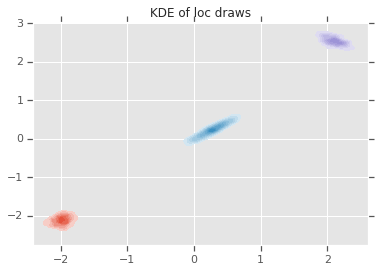

In [ ]:
loc_ = loc.numpy()
ax = sns.kdeplot(loc_[:,0,0], loc_[:,0,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:,1,0], loc_[:,1,1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:,2,0], loc_[:,2,1], shade=True, shade_lowest=False)
plt.title('KDE of loc draws');

## 결론

이 간단한 colab에서는 TensorFlow Probability 기본 형식을 사용하여 계층적 베이지안 혼합 모델을 빌드하는 방법을 보았습니다.